<a href="https://colab.research.google.com/github/nekdil566/Requirements-Issues-Detection-Tool/blob/main/Multi_class_text_classification_using_BERT_and_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/datasetforclassification.csv", encoding='latin1', usecols=['Base_Reviews','My_Labels']) 
df = df[pd.notnull(df['My_Labels'])]
print(df['Base_Reviews'].astype(str).apply(lambda x: len(x.split(' '))).sum())

212825


In [ ]:
df.head()

,My_Labels,Base_Reviews
0,sadness,I am crying . Bought and paid the app.and don'...
1,anger,downloaded and deleted because I faces problem...
2,sadness,From some time the app shows invalid file when...
3,disgust,You can only make calls to users of this app.I...
4,disgust,I couldn't even sign up it just exited out and...


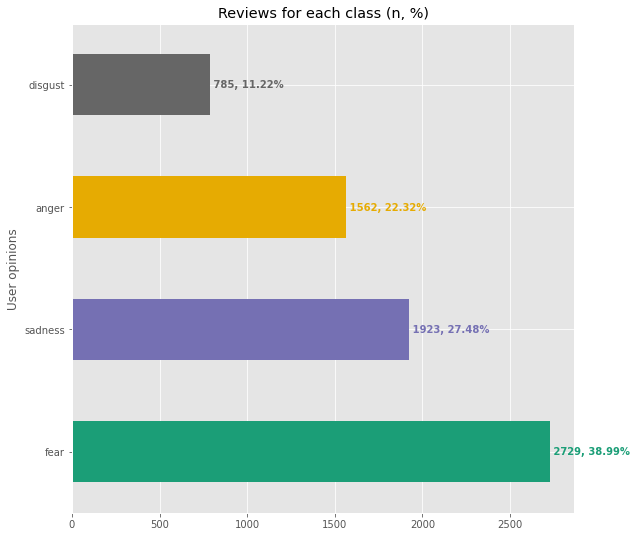

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df["My_Labels"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['My_Labels'].value_counts().plot.barh(title="Reviews for each class (n, %)", 
                                                 ylabel="User opinions",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df['My_Labels'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')
plt.savefig("Unbalanced-classes mode.png", dpi=500)

In [ ]:
df.My_Labels.value_counts()

fear       2729
sadness    1923
anger      1562
disgust     785
Name: My_Labels, dtype: int64

In [ ]:
# map topic descriptions to labels
df['Labels'] = df['My_Labels'].map({'anger': 0,
                                            'disgust': 1,
                                            'fear': 2,
                                            'sadness': 3,
                                            })

# drop unused column
df = df.drop(["My_Labels"], axis=1)

df.head()

,Base_Reviews,Labels
0,I am crying . Bought and paid the app.and don'...,3
1,downloaded and deleted because I faces problem...,0
2,From some time the app shows invalid file when...,3
3,You can only make calls to users of this app.I...,1
4,I couldn't even sign up it just exited out and...,1


In [ ]:
!pip install translate

In [ ]:
# for Colab users: !pip install translate
from translate import Translator
from termcolor import colored


translator= Translator(from_lang="it", to_lang="en")

def print_rand_example(df, col_name, col_value, chars=180):
  '''print a random review and its translation given a label
  Args:
    - df: input dataframe
    - col_name: column to use as filter (e.g. Label)
    - col_value: value of col_name to use as filter 
    - chars (optional, def:180) max number of characters to display
  '''
  original = df[df[col_name]==col_value].sample()["Base_Reviews"].values[0]
  translation = translator.translate(original).replace("&#39;","'")
  print(colored("\nOriginal", 'green', attrs=['bold','underline']))
  print(original[0:chars] + "...")
  # print(colored("\nTranslation", 'red', attrs=['bold','underline']))
  # print(translation[0:chars] + "...")

In [ ]:
print_rand_example(df, "Labels", 3)


Original
The app just started shutting down after a couple seconds and clearing the cache, clearing storage and even uninstalling annd reinstalling didn't fix it....


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['Base_Reviews'], y, test_size=0.25)

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 8.3 MB/s 
     |████████████████████████████████| 462 kB 50.2 MB/s 


In [ ]:
# for Colab users: !pip install tensorflow_text
import tensorflow_hub as hub
import tensorflow_text as text

# preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1")
# encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "The app requires you to sign in with your TV provider, if you want to watch live TV. If you have a TV provider, you don't need an app to watch live TV."]     #a corwd-user re
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-1.55069798e-01,  3.77764665e-02, -1.08223319e-01,
        -9.99568626e-02, -2.03205019e-01, -1.44666702e-01,
        -7.61939943e-01, -1.65342335e-02,  2.69775063e-01,
        -1.88751847e-01, -1.41040564e-01, -7.11688548e-02,
        -2.68637538e-01, -1.41134024e-01, -6.48698032e-01,
        -2.03602463e-01,  1.97162494e-01, -3.67311086e-03,
         1.03365272e-01, -1.88078642e-01, -6.26536980e-02,
        -6.89893365e-02, -4.49516952e-01,  3.24082136e-01,
        -4.81448978e-01, -1.20071435e+00, -1.28619328e-01,
        -1.22173972e-01, -4.58239615e-01, -7.82869756e-01,
        -3.49726140e-01, -5.53635418e-01, -6.08313143e-01,
        -5.57487488e-01, -6.36902004e-02,  2.33445922e-03,
        -3.07386994e-01,  2.84815907e-01, -9.02024359e-02,
        -1.32877514e-01, -2.51731604e-01, -1.87402755e-01,
        -3.38414103e-01,  5.79506397e-01,  6.49834424e-03,
         3.48034352e-02,  9.52855423e-02, -1.24588475e-01,
      

In [ ]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues", 
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

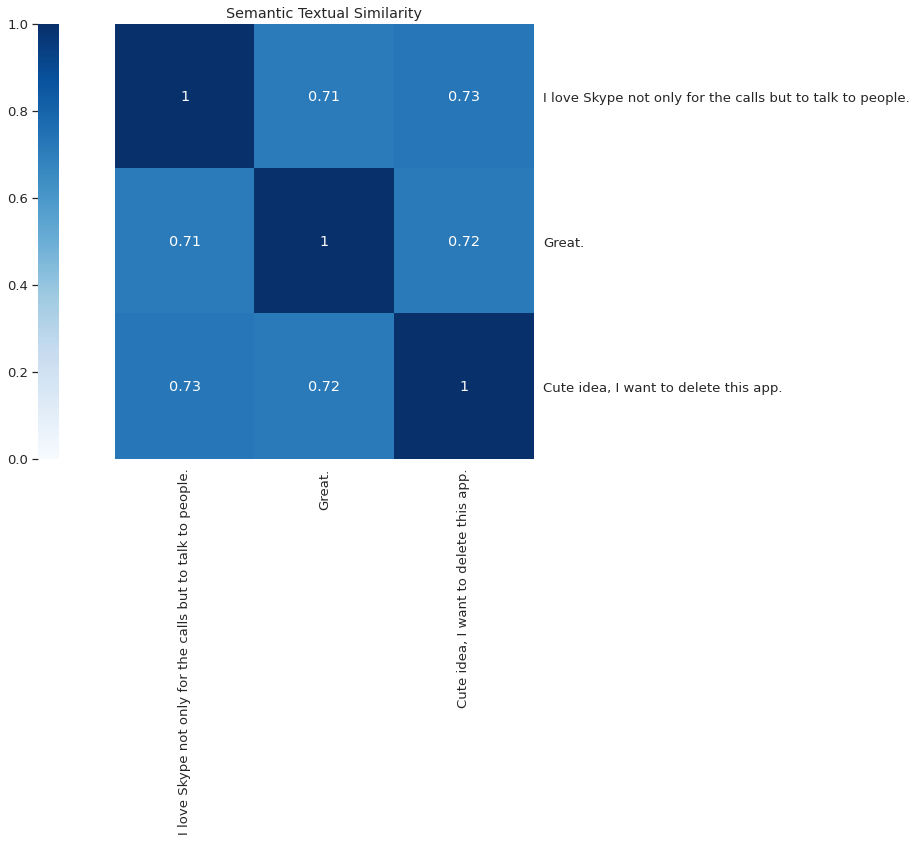

In [ ]:
reviews = ["I love Skype not only for the calls but to talk to people.",
           "Great.",
           "Cute idea, I want to delete this app."]

plot_similarity(get_embeddings(reviews), reviews)

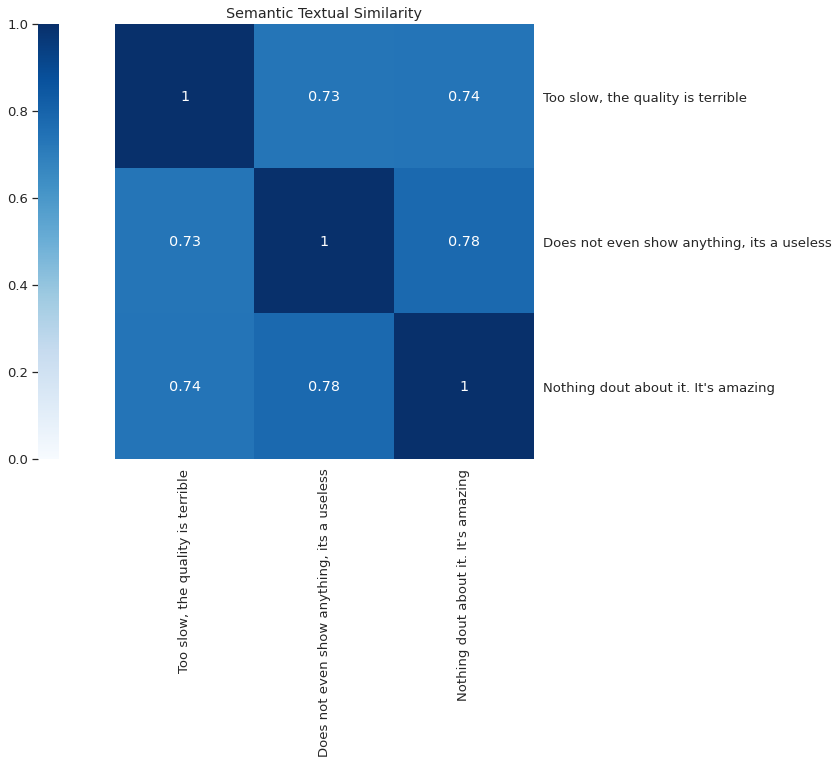

In [ ]:
reviews = ["Too slow, the quality is terrible",
           "Does not even show anything, its a useless",
           "Nothing dout about it. It's amazing"]

plot_similarity(get_embeddings(reviews), reviews)

In [ ]:
from keras import backend as K

def balance_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balance_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balance_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balance_precision(y_true, y_pred)
    recall = balance_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Base_Reviews')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balance_recall,
      balance_precision,
      balance_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/5
165/165 [==============================] - 3167s 19s/step - loss: 1.1725 - accuracy: 0.4622 - balance_recall: 0.1692 - balance_precision: 0.3846 - balance_f1_score: 0.2273 - val_loss: 1.0313 - val_accuracy: 0.5554 - val_balance_recall: 0.3391 - val_balance_precision: 0.5429 - val_balance_f1_score: 0.4116
Epoch 2/5
165/165 [==============================] - 3121s 19s/step - loss: 1.0063 - accuracy: 0.5677 - balance_recall: 0.3356 - balance_precision: 0.6209 - balance_f1_score: 0.4318 - val_loss: 0.9624 - val_accuracy: 0.5920 - val_balance_recall: 0.3788 - val_balance_precision: 0.6631 - val_balance_f1_score: 0.4772
Epoch 3/5
165/165 [==============================] - 3223s 20s/step - loss: 0.9452 - accuracy: 0.6003 - balance_recall: 0.4149 - balance_precision: 0.6752 - balance_f1_score: 0.5103 - val_loss: 0.9163 - val_accuracy: 0.6360 - val_balance_recall: 0.4362 - val_balance_precision: 0.7088 - val_balance_f1_score: 0.5352
Epoch 4/5
165/165 [==============================] -

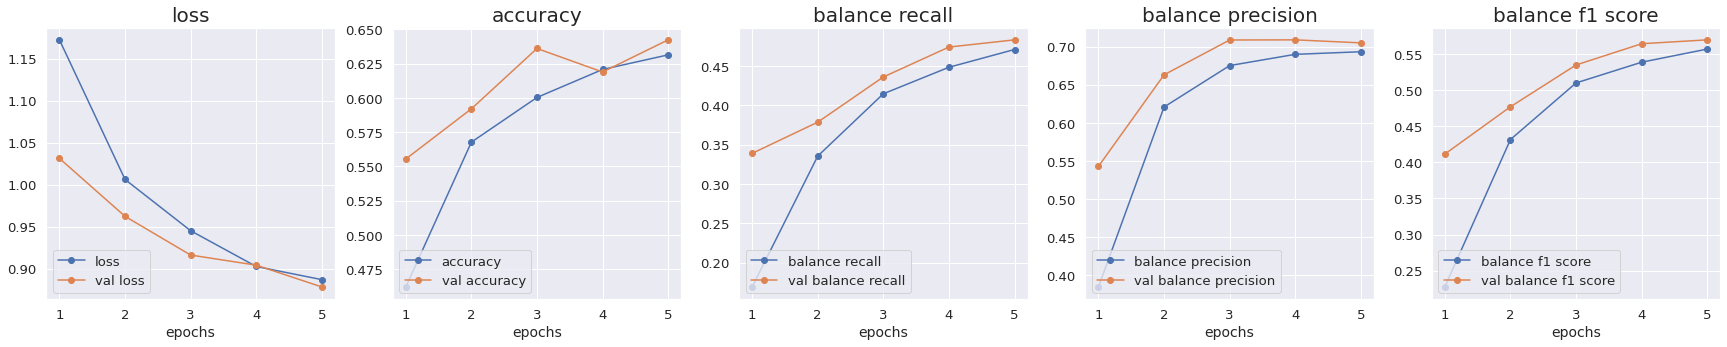

In [ ]:

x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")
plt.savefig("BERT-accuracy mode.png", dpi=300)